# Dynamic Time Warping

Based on:
http://nipunbatra.github.io/2014/07/dtw/  

In [1]:
import numpy
import matplotlib.pyplot as plt
import matplotlib 
import sys

In [2]:
# Remember to install it first!
from dtw_python import *

In [3]:
def distance_cost_plot(distances,xlabel="x",ylabel="y",all_ticks=False,figure=True):
    distances=distances.T
    if figure:
        plt.figure(figsize =(10,10))
    plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if all_ticks:
        plt.xticks(range(distances.shape[1]),range(distances.shape[1]))
        plt.yticks(range(distances.shape[0]),range(distances.shape[0]))
    plt.grid()
    plt.colorbar();

In [4]:
def path_cost_p(x, y, accumulated_cost, distances):
    
    path = [[len(x)-1, len(y)-1]]
    
    cost = 0
    
    i = len(x)-1
    j = len(y)-1
    
    while i>0 or j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j = j - 1
        path.append([i, j])
    for [x, y] in path:
        cost = cost +distances[x, y]
    return path, cost

In [5]:
def generates_accumulated_cost_p(x,y,distances):
    accumulated_cost = numpy.zeros((len(x), len(y)))
    
    accumulated_cost[0,0] = distances[0,0]
    
    for i in range(1, len(x)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]

    for j in range(1, len(y)):
        accumulated_cost[0,j] = distances[0,j] + accumulated_cost[0, j-1]
        
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
            
    return accumulated_cost

In [6]:
def generates_distances2D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2))

In [7]:
def generates_distances3D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)
    z_all=(x[:,2]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2+(z_all.T-y[:,2])**2))

In [8]:
def generates_distances_N(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping 
    => for systems with N dimensions
    '''
    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        x=x.reshape((x.shape[0],1))
        y=y.reshape((y.shape[0],1))
    
    assert x.shape[1]==y.shape[1], "Inputs must have the same number of columns" # verifies if the second dimension matches
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # returns all the distances between original points and generated ones
    return (numpy.sqrt(numpy.array([((x[:,i]*helper_matrix).T-y[:,i])**2 for i in range(x.shape[1])]).sum(axis=0)))

# Examples

## Example 1
### Using only Numpy

[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 4.]]


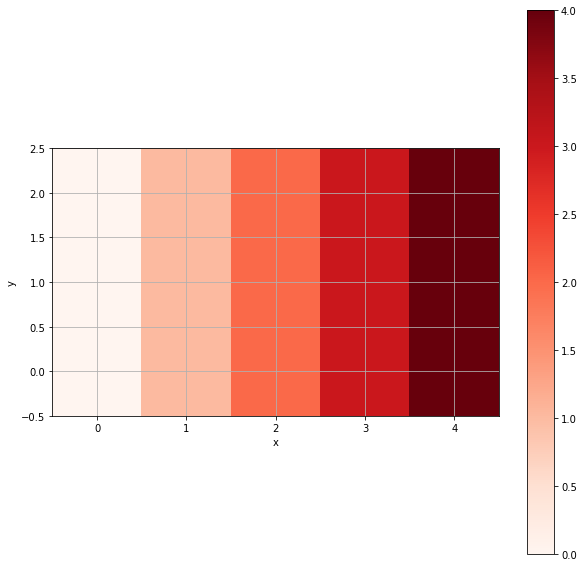

In [13]:
x = numpy.array([0,1,2,3,4])
y = numpy.zeros(3)

dist=generates_distances_N(x,y)
print(dist)
distance_cost_plot(dist)

### Using C version

[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 4.]]


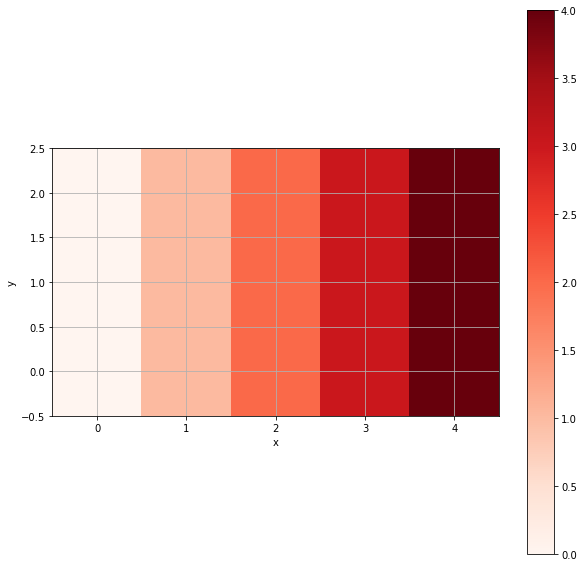

In [14]:
dist=distances_matrix(x,y)
print(dist)
distance_cost_plot(dist)

## Example 2
### Using only Numpy

[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]]


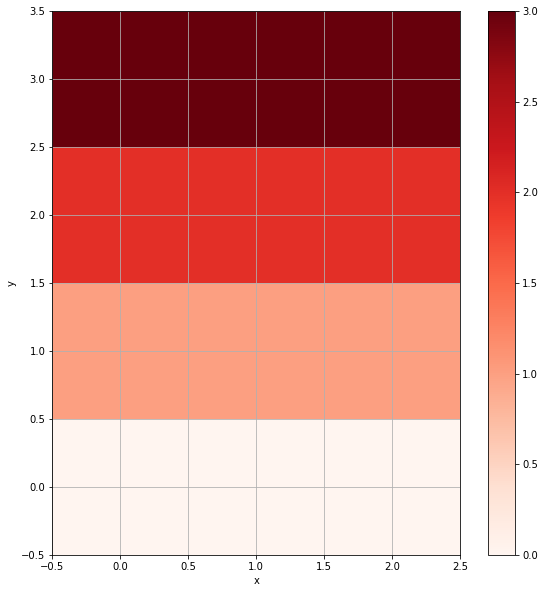

In [15]:
x = numpy.zeros(3)
y = numpy.array([0,1,2,3])

dist=generates_distances_N(x,y)
print(dist)
distance_cost_plot(dist)

# Using C version

[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]]


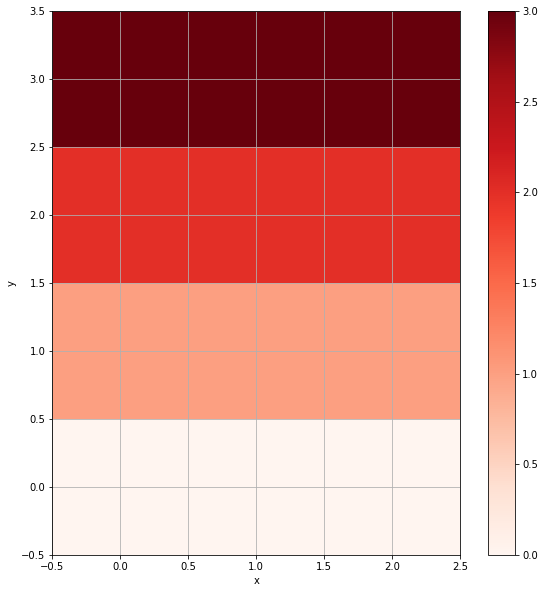

In [16]:
dist=distances_matrix(x,y)
print(dist)
distance_cost_plot(dist)

## Example 3
### Using only Numpy

[[1. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


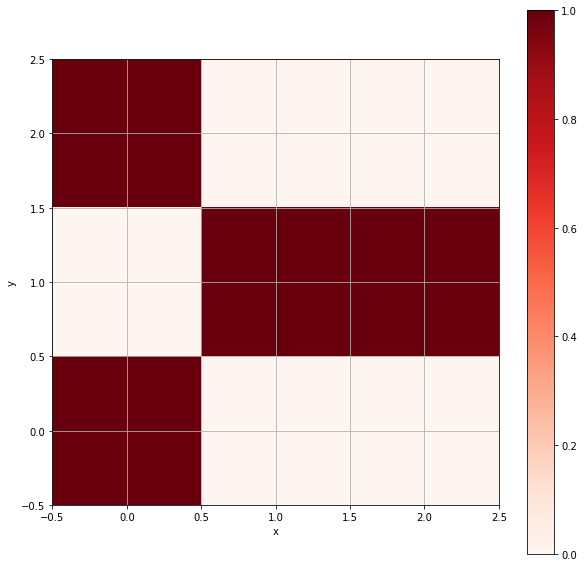

In [19]:
x = numpy.zeros((3,4))
y = numpy.zeros((3,4))

x[0,:]=[1,0,0,0]

y[1,:]=[1,0,0,0]

dist=generates_distances_N(x,y)
print(dist)
distance_cost_plot(dist)

### Using C version

[[1. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


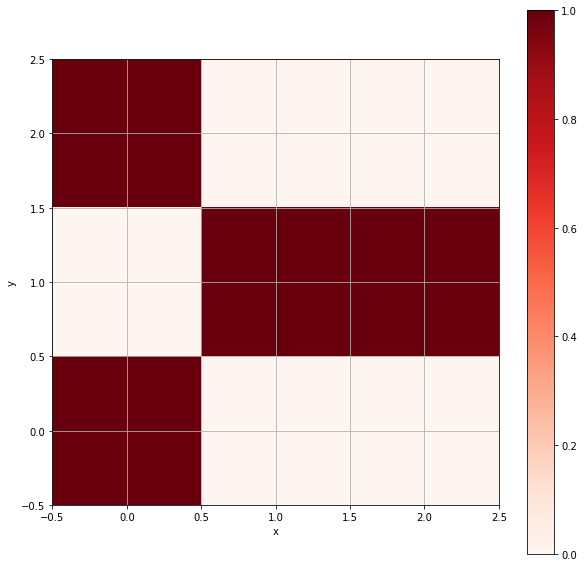

In [20]:
dist=distances_matrix(x,y)
print(dist)
distance_cost_plot(dist)

## Example 4
### Using only Numpy

[[1.         1.41421356 1.        ]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]


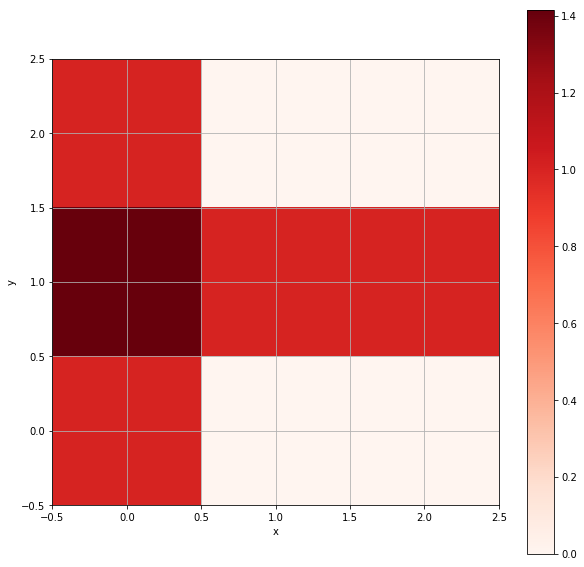

In [21]:
x = numpy.zeros((3,4))
y = numpy.zeros((3,4))

x[0,:]=[0,1,0,0]

y[1,:]=[1,0,0,0]

dist=generates_distances_N(x,y)
print(dist)
distance_cost_plot(dist)

### Using C version

[[1.        1.4142135 1.       ]
 [0.        1.        0.       ]
 [0.        1.        0.       ]]


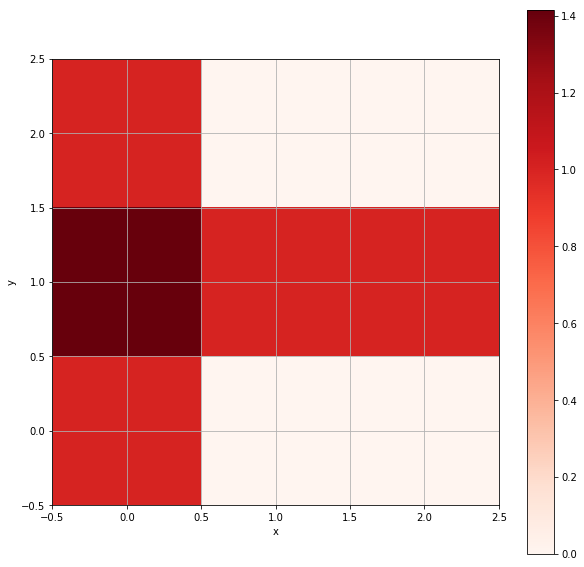

In [22]:
dist=distances_matrix(x,y)
print(dist)
distance_cost_plot(dist)

## Example 5
### Comparing speed between Numpy and C version

In [23]:
x = numpy.random.rand(300,4)
y = numpy.random.rand(500,4)

In [24]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 700 µs, sys: 8.53 ms, total: 9.23 ms
Wall time: 8.55 ms


In [26]:
%%time
dist=distances_matrix(x,y)

CPU times: user 4.67 ms, sys: 0 ns, total: 4.67 ms
Wall time: 4.83 ms


In [27]:
%%time
accumulated_cost=accumulated_cost_matrix(x,y,dist)

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 1.64 ms


In [28]:
%%time
path,cost = path_cost_calculation(x,y,dist,accumulated_cost)

CPU times: user 1.02 ms, sys: 0 ns, total: 1.02 ms
Wall time: 1.15 ms


In [29]:
x = numpy.random.rand(3000,3)
y = numpy.random.rand(5000,3)

In [30]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 549 ms, sys: 305 ms, total: 854 ms
Wall time: 856 ms


In [31]:
%%time
dist=generates_distances3D(x,y)

CPU times: user 203 ms, sys: 236 ms, total: 440 ms
Wall time: 440 ms


In [32]:
%%time
dist=distances_matrix(x,y)

CPU times: user 98.3 ms, sys: 25.7 ms, total: 124 ms
Wall time: 124 ms


In [33]:
x = numpy.random.rand(3000,2)
y = numpy.random.rand(5000,2)

In [34]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 342 ms, sys: 265 ms, total: 607 ms
Wall time: 606 ms


In [31]:
%%time
dist=generates_distances2D(x,y)

CPU times: user 297 ms, sys: 133 ms, total: 430 ms
Wall time: 429 ms


In [35]:
%%time
dist=distances_matrix(x,y)

CPU times: user 95.2 ms, sys: 20.5 ms, total: 116 ms
Wall time: 117 ms


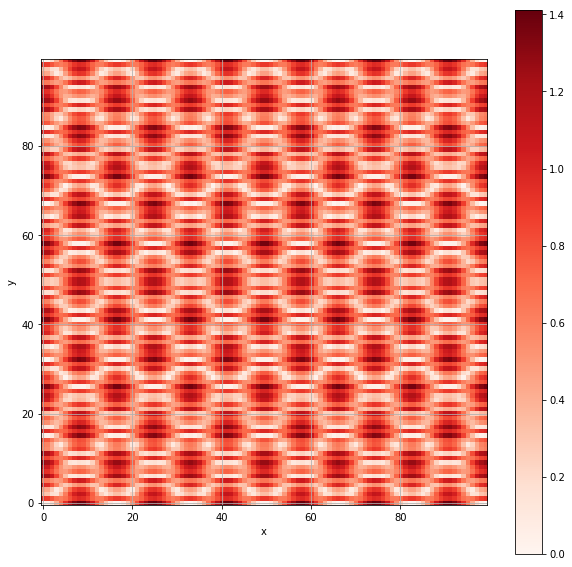

In [36]:
x = numpy.zeros((100,2))
x[:,1]=numpy.sin(numpy.linspace(0,6*numpy.pi,num=100))**2
x[:,0]=numpy.cos(numpy.linspace(0,6*numpy.pi,num=100))**2

y = numpy.zeros((100,2))
y[:,1]=numpy.sin(20*numpy.linspace(0,2*numpy.pi,num=100))**2
y[:,0]=x[:,0]#numpy.cos(numpy.linspace(0,2*numpy.pi,num=100))**2

dist=generates_distances_N(x,y)
distance_cost_plot(dist)

In [37]:
%%time
dist=generates_distances2D(x,y)

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2.23 ms


In [38]:
%%time
accumulated_cost=generates_accumulated_cost_p(x,y,dist)

CPU times: user 20.2 ms, sys: 157 µs, total: 20.3 ms
Wall time: 20.2 ms


In [39]:
%%time
path,cost = path_cost_p(x, y, accumulated_cost, dist)
path=numpy.array(path)
print(cost)

38.09263385402844
CPU times: user 2.57 ms, sys: 886 µs, total: 3.46 ms
Wall time: 3.69 ms


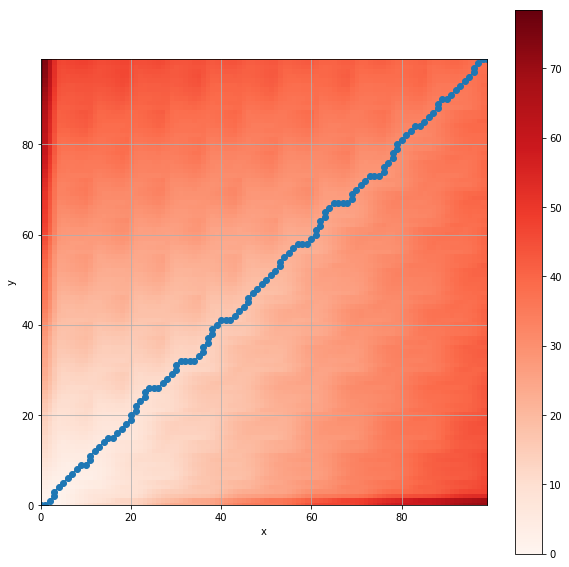

In [40]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

In [41]:
%%time
dist=distances_matrix(x,y)

CPU times: user 687 µs, sys: 495 µs, total: 1.18 ms
Wall time: 1.19 ms


In [42]:
%%time
accumulated_cost=accumulated_cost_matrix(x,y,dist)

CPU times: user 308 µs, sys: 221 µs, total: 529 µs
Wall time: 537 µs


In [43]:
%%time
path,cost = path_cost_calculation(x,y,dist,accumulated_cost)

CPU times: user 731 µs, sys: 526 µs, total: 1.26 ms
Wall time: 636 µs


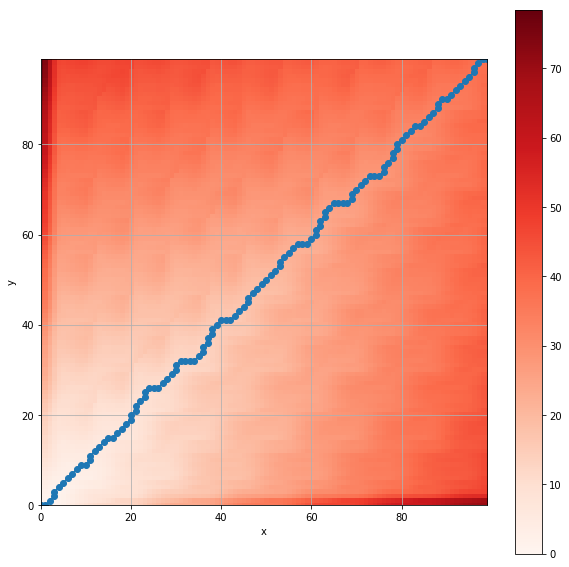

In [44]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

## Example 6
### Reproducing the sin / cosine example from http://nipunbatra.github.io/2014/07/dtw/

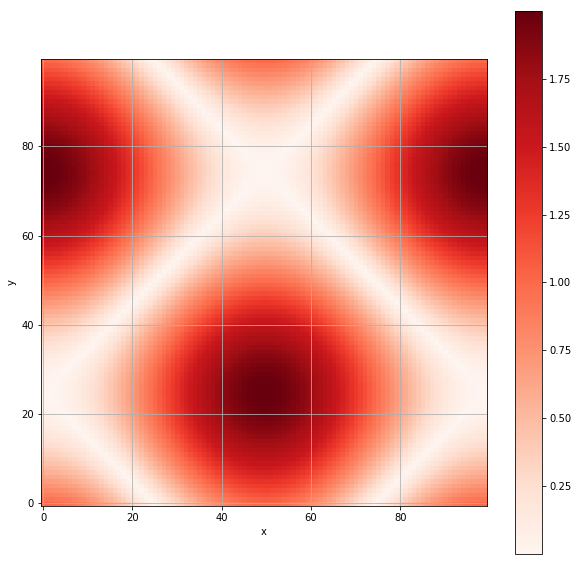

In [45]:
idx = numpy.linspace(0, 6.28, 100)
idy = numpy.linspace(0, 6.28, 100)
x = numpy.cos(idx)
y = numpy.sin(idy)
dist=distances_matrix(x,y)
distance_cost_plot(dist)

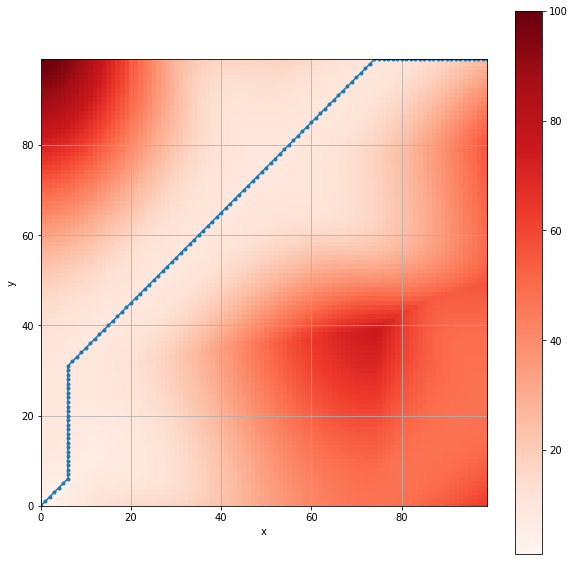

In [46]:
accumulated_cost = accumulated_cost_matrix(x,y,dist)
path,cost = path_cost_calculation(x,y,dist,accumulated_cost)

distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'.-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

In [47]:
cost,\
numpy.array([dist[i,j] for i,j in zip(path[:,0],path[:,1])]).sum(),\
numpy.array([accumulated_cost[i,j] for i,j in zip(path[:,0],path[:,1])]).sum(),\
accumulated_cost[-1,-1]/sum(accumulated_cost.shape) # Same cost as in https://pypi.python.org/pypi/dtw/1.0

(25.869739532470703, 25.869736, 1252.7753, 0.12934865951538085)

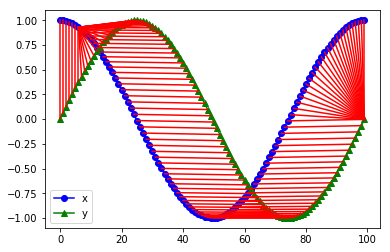

In [48]:
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
for [map_x, map_y] in path:
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

# Example 7 - Circle vs Cardioid

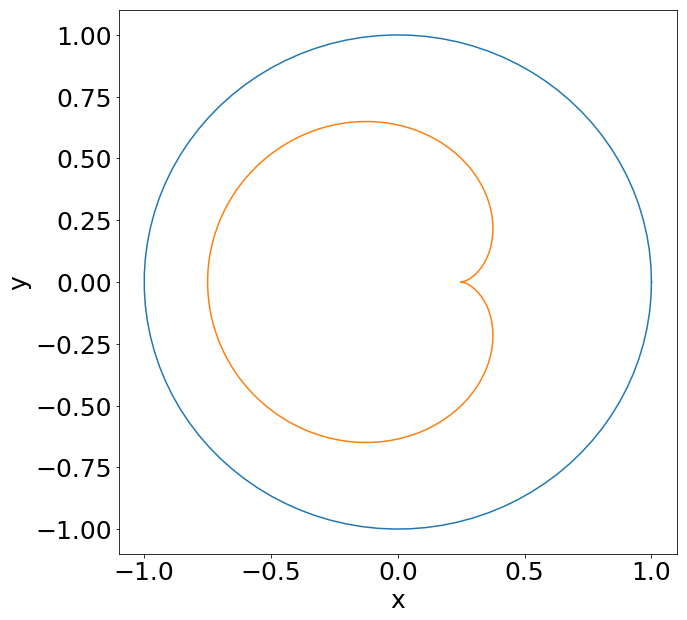

In [49]:
t1 = numpy.linspace(0, 2*numpy.pi, 100)
t2 = numpy.linspace(0, 2*numpy.pi, 200)

dz_start = 50
dz_end = 150

temp = numpy.copy(t2[dz_start:])
t2[dz_start:dz_end]=t2[dz_start]
t2=numpy.concatenate((t2[:dz_end],temp))

circle = numpy.zeros((100,2))
circle[:,1] = numpy.sin(t1)
circle[:,0] = numpy.cos(t1)

cardioid = numpy.zeros((len(t2),2))
cardioid[:,1] = 0.25*(2*numpy.sin(t2)-numpy.sin(2*t2))
cardioid[:,0] = 0.25*(2*numpy.cos(t2)-numpy.cos(2*t2))



font = {'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

plt.figure(figsize =(10,10))
plt.plot(circle[:,0],circle[:,1])
plt.plot(cardioid[:,0],cardioid[:,1])
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


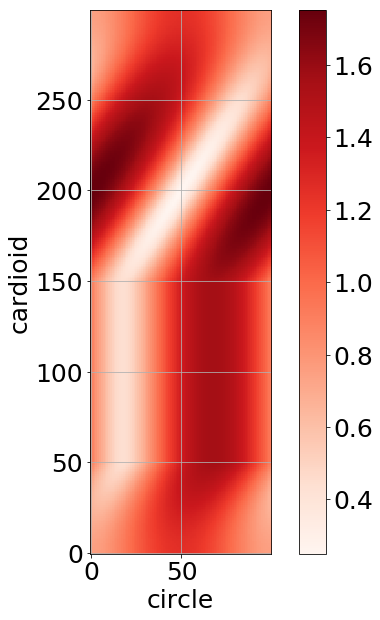

In [50]:
dist = distances_matrix(circle,cardioid)
distance_cost_plot(dist,xlabel="circle",ylabel="cardioid")

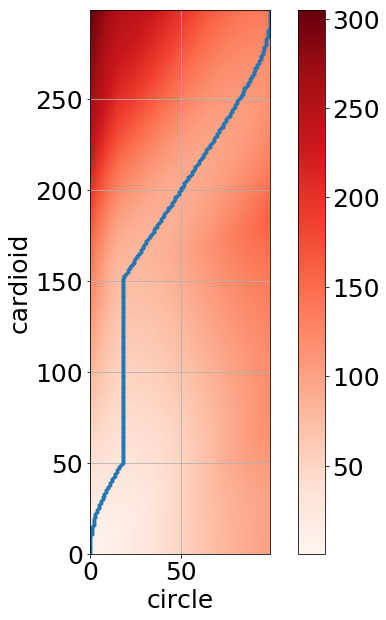

In [51]:
accumulated_cost = accumulated_cost_matrix(circle,cardioid,dist)
path,cost = path_cost_calculation(circle,cardioid,dist,accumulated_cost)

distance_cost_plot(accumulated_cost,xlabel="circle",ylabel="cardioid")
plt.plot(path[:,0],path[:,1],'.-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

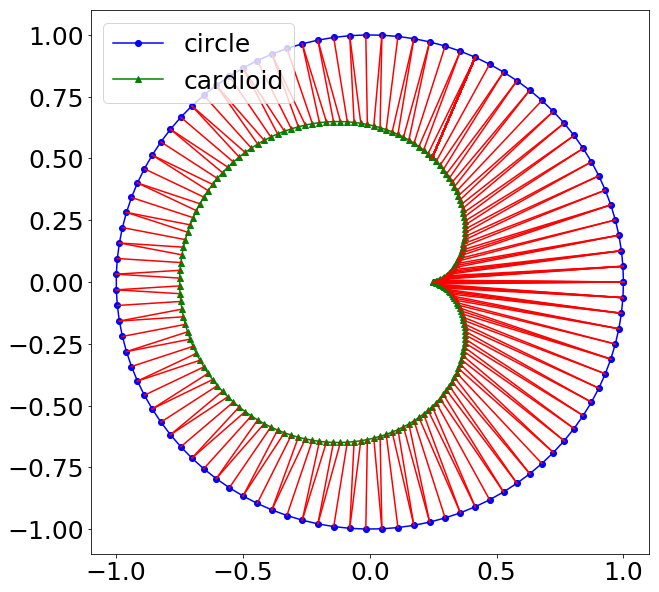

In [52]:
font = {'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

plt.figure(figsize =(10,10))

plt.plot(circle[:,0],circle[:,1], 'bo-' ,label='circle')
plt.plot(cardioid[:,0],cardioid[:,1], 'g^-', label = 'cardioid')
plt.legend();
for [map_c, map_e] in path:
    plt.plot([circle[map_c,0],cardioid[map_e,0]],[circle[map_c,1],cardioid[map_e,1]] , 'r')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.show()

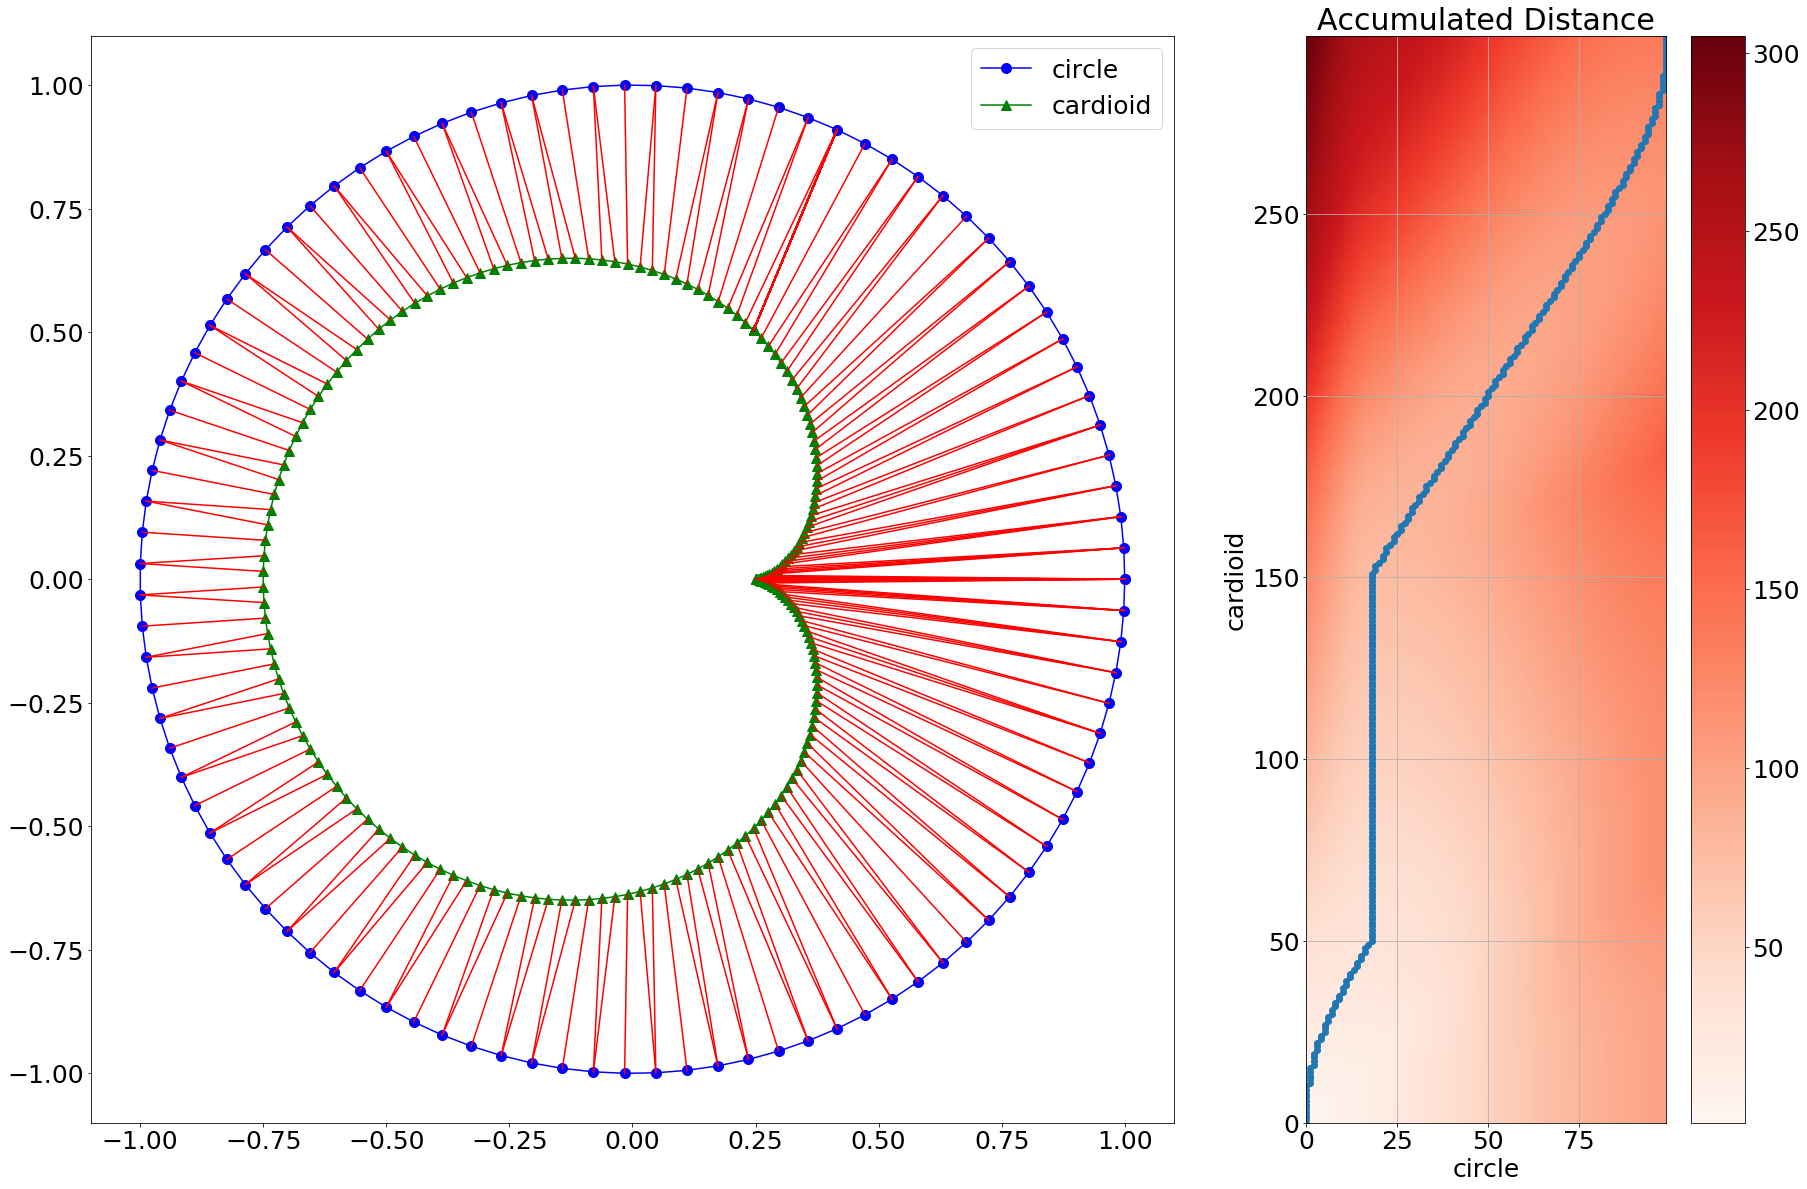

In [53]:
import os

font = {'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

plt.figure(figsize =(30,20))
plt.subplot2grid((1,3),(0,0),colspan=2)
plt.plot(circle[:,0],circle[:,1], 'bo-' ,label='circle', markersize=10)
plt.plot(cardioid[:,0],cardioid[:,1], 'g^-', label = 'cardioid', markersize=10)
plt.legend();
for [map_c, map_e] in path:
    plt.plot([circle[map_c,0],cardioid[map_e,0]],[circle[map_c,1],cardioid[map_e,1]] , 'r')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

plt.subplot2grid((1,3),(0,2))
distance_cost_plot(accumulated_cost,xlabel="circle",ylabel="cardioid", figure=False)
plt.title("Accumulated Distance")
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])

plt.savefig("./cardioid_dtw.pdf", bbox_inches='tight',pad_inches=.1)
plt.show()

# Example 9 
## Tested up to this point using [my latest docker image](https://ricardodeazambuja.com/deep_learning/2019/01/31/tuning_tensorflow_docker_updated/).

In [55]:
from dtw import dtw
# https://pypi.python.org/pypi/dtw/1.0

In [117]:
dist, cost, path = dtw(x, y)

In [118]:
dist

0.31984152653057513

In [119]:
cost_array=[cost[i,j] for i,j in zip(path[0],path[1])]

In [120]:
numpy.array(cost_array).sum()

4133.7716653067419

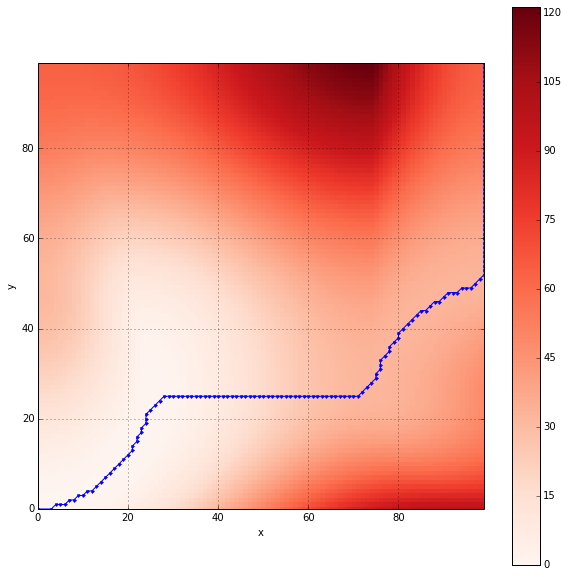

In [121]:
distance_cost_plot(cost)
plt.plot(path[0], path[1],'.-')
plt.xlim(0,path[0][-1])
plt.ylim(0,path[1][-1])
plt.show()

# Example 8 - Speech recognition?
## It's necessary to install portaudio (brew install portaudio) and pyaudio (pip install pyaudio)

In [41]:
samples = [] # list used to save the different recordings

In [55]:
# Records directly from the computer microphone

# http://stackoverflow.com/a/29722090
import pyaudio

RATE = 16000
RECORD_SECONDS = 2.5
CHUNKSIZE = 1024

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

frames = [] # A python-list of chunks(numpy.ndarray)
for _ in range(0, int(RATE / CHUNKSIZE * RECORD_SECONDS)):
    data = stream.read(CHUNKSIZE)
    frames.append(numpy.fromstring(data, dtype=numpy.int16))

#Convert the list of numpy-arrays into a 1D array (column-wise)
numpydata = numpy.hstack(frames)

# close stream
stream.stop_stream()
stream.close()
p.terminate()

samples.append(numpydata)

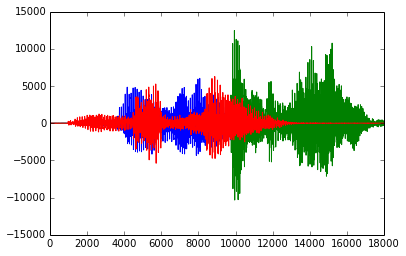

In [74]:
# plot data
import matplotlib.pyplot as plt
%matplotlib inline

for s in samples:
    plt.plot(s[8000:26000])
plt.show()

In [75]:
x = (samples[0][8000:26000])[::4]
y = (samples[2][8000:26000])[::4]

In [76]:
dist=distances_matrix(x,y)

In [77]:
accumulated_cost=accumulated_cost_matrix(x,y,dist)

In [78]:
path,cost = path_cost_calculation(x,y,dist,accumulated_cost)

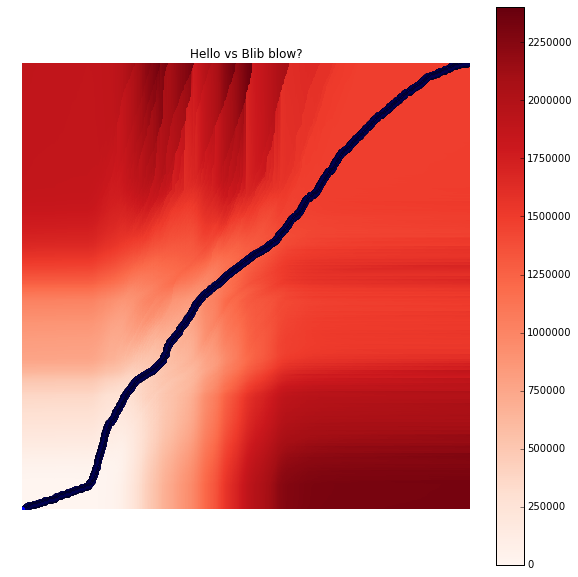

In [79]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.axis('off')
plt.xticks([],[])# avoids white spaces
plt.yticks([],[])# avoids white spaces
plt.title("Hello vs Blib blow?")
plt.show()

In [80]:
x = (samples[0][8000:26000])[::4]
y = (samples[1][8000:26000])[::4]

In [81]:
dist=distances_matrix(x,y)

In [82]:
accumulated_cost=accumulated_cost_matrix(x,y,dist)

In [83]:
path,cost = path_cost_calculation(x,y,dist,accumulated_cost)

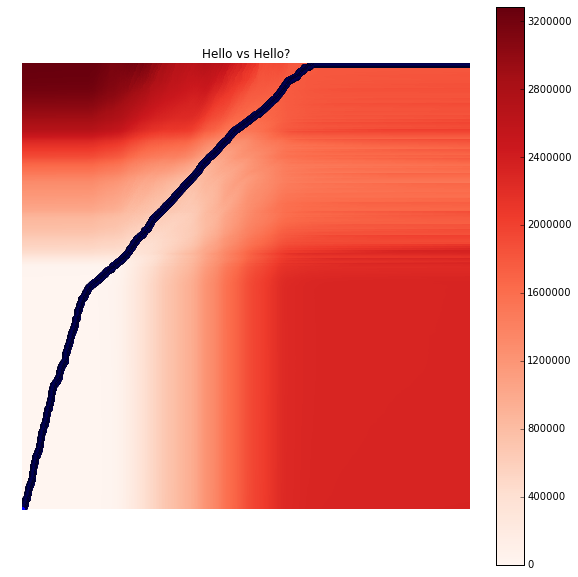

In [84]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.axis('off')
plt.xticks([],[])# avoids white spaces
plt.yticks([],[])# avoids white spaces
plt.title("Hello vs Hello?")
plt.show()

Other sources of information about DTW:  
https://pypi.python.org/pypi/dtw/1.0  
https://github.com/pierre-rouanet/dtw  
http://mlpy.sourceforge.net/docs/3.5/dtw.html  
http://alexminnaar.com/time-series-classification-and-clustering-with-python.html  
http://www.psb.ugent.be/cbd/papers/gentxwarper/DTWalgorithm.htm  
https://www.researchgate.net/profile/Pavel_Senin/publication/228785661_Dynamic_Time_Warping_Algorithm_Review/links/02bfe5100f11a7929f000000.pdf  
http://insy.ewi.tudelft.nl/content/multi-dimensional-dynamic-time-warping-gesture-recognition  
http://epubs.siam.org/doi/pdf/10.1137/1.9781611972757.50  
http://www.mblondel.org/journal/2009/08/31/dynamic-time-warping-theory/  
http://dx.doi.org/10.1371/journal.pone.0136577  
https://docs.google.com/viewer?url=http%3A%2F%2Fwww.psb.ugent.be%2Fcbd%2Fpapers%2Fgentxwarper%2FDTWAlgorithm.ppt  
http://www.cs.rutgers.edu/~mlittman/courses/lightai03/DDTW-2001.pdf  
http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/132_dtw.pdf